In [1]:
#!pip install --upgrade ipywidgets
#!pip install --upgrade tqdm

In [2]:
import torch
import numpy as np

# version and gpu
print(torch.__version__)
print(torch.cuda.is_available())

# add gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

2.2.1+cu121
True
cuda


In [3]:
# load data 
# Load data
data_paths = [
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"
]

manta, xiris, y, feats = [np.load(path) for path in data_paths]
print("manta shape:", manta.shape)
print("xiris shape:", xiris.shape)
print("y shape:", y.shape)
print("feats shape:", feats.shape)

manta shape: (9587, 320, 320)
xiris shape: (9587, 320, 320)
y shape: (9587, 2)
feats shape: (9587, 8)


In [4]:
# expand dimensions
manta = np.expand_dims(manta, axis=1)
xiris = np.expand_dims(xiris, axis=1)

print("manta shape:", manta.shape)

# create X that concatnates manta and xiris where manta is the first channel and xiris is the second an manta again in 3rd channel
X = np.concatenate((manta, xiris, manta), axis=1)
print("X shape:", X.shape) # (n_samples, n_channels, height, width)

manta shape: (9587, 1, 320, 320)
X shape: (9587, 3, 320, 320)


In [5]:
# lenght and height -> y
# Get max of each column and normalize
y = feats[:, 1:3]
max_y = np.max(y, axis=0)
y = y / max_y

print("y shape:", y.shape)
print("y max:", max_y)

y shape: (9587, 2)
y max: [225. 158.]


In [6]:
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

del X, y, manta, xiris, feats

In [ ]:
BATCH_SIZE = 32
# create a dataloader and transfor the data (resize to target size of 224x224)
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# img = transform.resize(image, (new_h, new_w))

# apply data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
])

# create dataset
class CustomDataset(TensorDataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
        # convert to tensor
        self.X = torch.tensor(self.X, dtype=torch.float32).to(device)
        self.y = torch.tensor(self.y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label
    
# create dataloaders
train_dataset = CustomDataset(X_train, y_train, transform_train)
val_dataset = CustomDataset(X_val, y_val, transform_test)
test_dataset = CustomDataset(X_test, y_test, transform_test)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

del X_train, X_val, X_test, y_train, y_val, y_test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224])
Max val: 1.0000001192092896
Min: 0.0043243952095508575


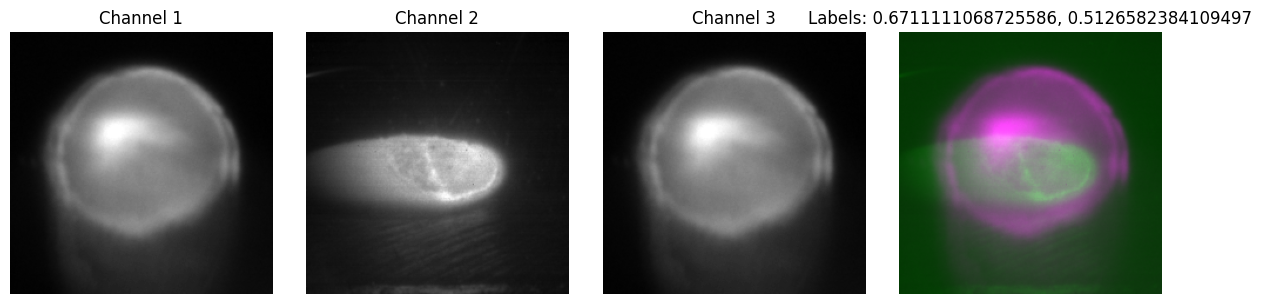

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize images from DataLoader
def visualize_single_image(dataloader):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch 
    
    # Get the first image
    img = images[0]
    
    # get to cpu
    img = img.cpu()
    # print shape
    print("Image shape:", img.shape)
    
    # Print max and min values for each channel in the current image
    print("Max val:", torch.max(img).item())
    print("Min:",  torch.min(img).item())

    # Convert to numpy array
    #img = img.numpy()
    
    # Plot the image
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for j in range(3):  # Plot each channel separately
        axes[j].imshow(img[j], cmap='gray')
        axes[j].set_title(f"Channel {j+1}")
        axes[j].axis('off')
    # Plot the combined image
    combined_img = np.transpose(img, (1,2,0))
    axes[3].imshow(combined_img)
    label_text = f"Labels: {', '.join([str(label.item()) for label in labels[0]])}"
    axes[3].set_title(label_text)
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()
    

# Visualize one image from training DataLoader
visualize_single_image(val_dataloader)

# Function to visualize images from DataLoader
def visualize_multiple_images(dataloader, num_images=2):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch
    
    # Plot the images
    fig, axes = plt.subplots(num_images, 4, figsize=(12, 6))
    for i in range(num_images):
        img = images[i]  # Fetch the image
        # get to cpu
        img = img.cpu()
        for j in range(3):  # Plot each channel separately
            axes[i, j].imshow(img[j], cmap='gray')
            axes[i, j].set_title(f"Channel {j+1}")
            axes[i, j].axis('off')
        # Plot the combined image
        combined_img = np.transpose(img, (1,2,0))
        axes[i, 3].imshow(combined_img)
        label_text = f"Labels: {', '.join([str(label.item()) for label in labels[i]])}"
        axes[i, 3].set_title(label_text)
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images from training DataLoader
#visualize_multiple_images(train_loader, num_images=2)
# Visualize images from testing DataLoader
# visualize_multiple_images(dataloader_test, num_images=2)



In [ ]:
from torch import nn
import torch.nn.functional as F

# Define the model

class SimpleCNN_reg(nn.Module):
    def __init__(self):
        super(SimpleCNN_reg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 4 channels -> 3 channels + batch size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*28*28, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Create the model
model = SimpleCNN_reg()
print(model)   

SimpleCNN_reg(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
from tqdm import tqdm 

# Assuming 'model' is already defined and needs to be moved to the appropriate device
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 5
train_losses = []
val_losses = []
len_train_loader = len(train_dataloader)
len_val_loader = len(val_dataloader)

for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0.0
    # Wrap the training data loader with tqdm
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')):
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len_train_loader
    train_losses.append(train_loss)
    
    # Evaluation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        # Wrap the testing data loader with tqdm
        for batch in tqdm(val_dataloader, desc='Validation'):
            images, labels = batch# Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len_val_loader
    val_losses.append(val_loss)
    
    # Print training and validation information
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Optionally save the trained model
#torch.save(model.state_dict(), 'trained_model.pth')


Validation: 100%|██████████| 48/48 [00:00<00:00, 152.04it/s]


Epoch 1/10, Training Loss: 0.0768, Validation Loss: 0.0013


Validation: 100%|██████████| 48/48 [00:00<00:00, 161.70it/s]


Epoch 2/10, Training Loss: 0.0010, Validation Loss: 0.0007


Validation: 100%|██████████| 48/48 [00:00<00:00, 157.00it/s]


Epoch 3/10, Training Loss: 0.0007, Validation Loss: 0.0006


Validation: 100%|██████████| 48/48 [00:00<00:00, 157.29it/s]


Epoch 4/10, Training Loss: 0.0006, Validation Loss: 0.0004


Validation: 100%|██████████| 48/48 [00:00<00:00, 106.42it/s]


Epoch 5/10, Training Loss: 0.0006, Validation Loss: 0.0004


Validation: 100%|██████████| 48/48 [00:00<00:00, 119.23it/s]


Epoch 6/10, Training Loss: 0.0005, Validation Loss: 0.0006


Validation: 100%|██████████| 48/48 [00:00<00:00, 119.35it/s]


Epoch 7/10, Training Loss: 0.0005, Validation Loss: 0.0004


Validation: 100%|██████████| 48/48 [00:00<00:00, 146.53it/s]


Epoch 8/10, Training Loss: 0.0005, Validation Loss: 0.0003


Validation: 100%|██████████| 48/48 [00:00<00:00, 124.55it/s]


Epoch 9/10, Training Loss: 0.0005, Validation Loss: 0.0003


Validation: 100%|██████████| 48/48 [00:00<00:00, 131.21it/s]

Epoch 10/10, Training Loss: 0.0005, Validation Loss: 0.0003


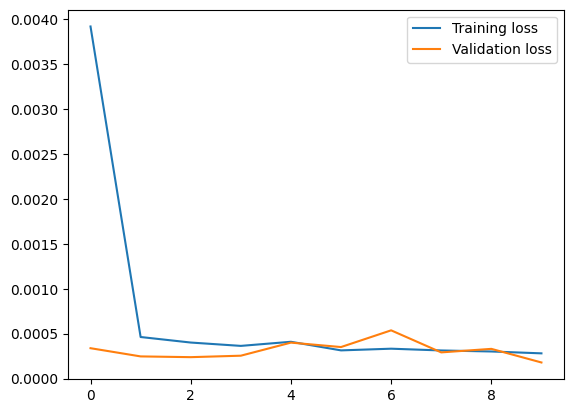

In [ ]:
# plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()


In [ ]:
# print layer names 
for name, param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([32, 3, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 3, 3])
conv3.bias torch.Size([128])
fc1.weight torch.Size([512, 100352])
fc1.bias torch.Size([512])
fc2.weight torch.Size([2, 512])
fc2.bias torch.Size([2])


Validation:   0%|          | 0/60 [00:00<?, ?it/s]

Validation: 100%|██████████| 60/60 [00:00<00:00, 119.03it/s]


Mean Squared Error: 0.0003


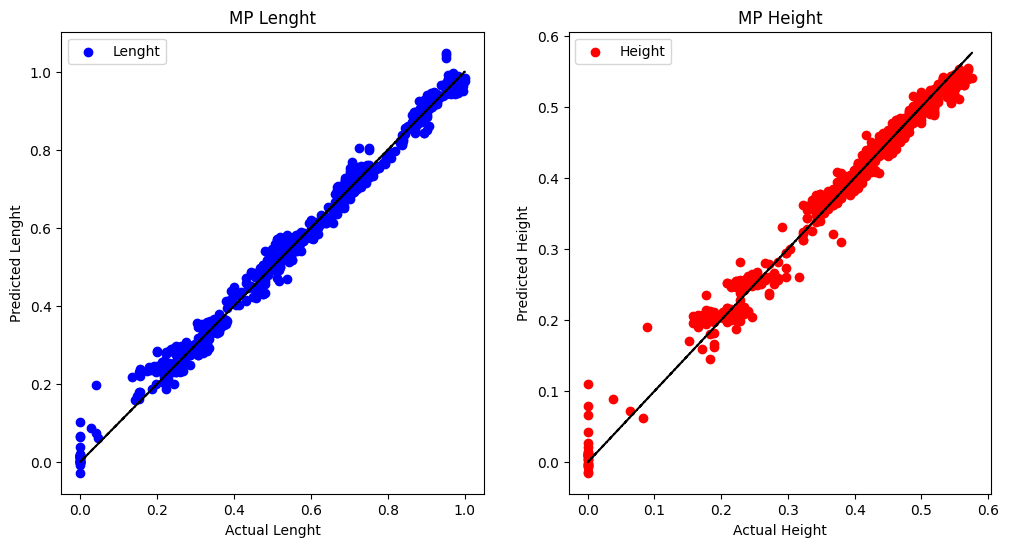

In [ ]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predicted and actual labels
predicted_labels = []
actual_labels = []

# No need to track gradients during validation
with torch.no_grad():
    # Iterate over the test DataLoader
    for batch in tqdm(test_dataloader, desc='Validation'):
        images, labels = batch # Move data to GPU
        outputs = model(images)
        predicted_labels.append(outputs.cpu())  # Move predictions to CPU
        actual_labels.append(labels.cpu())  # Move actual labels to CPU

# Concatenate the lists to obtain the predicted and actual labels
predicted_labels = torch.cat(predicted_labels)
actual_labels = torch.cat(actual_labels)

# Calculate the mean squared error
mse = nn.MSELoss()
loss = mse(predicted_labels, actual_labels)
print(f"Mean Squared Error: {loss.item():.4f}")

# Plot the predicted and actual labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(actual_labels[:, 0], predicted_labels[:, 0], label='Lenght', color='blue')
plt.plot(actual_labels[:, 0], actual_labels[:, 0], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Lenght')
plt.ylabel('Predicted Lenght')
plt.title('MP Lenght')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(actual_labels[:, 1], predicted_labels[:, 1], label='Height', color='red')
plt.plot(actual_labels[:, 1], actual_labels[:, 1], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Height')
plt.ylabel('Predicted Height')
plt.title('MP Height')
plt.legend()

#plt.tight_layout()
plt.show()


In [ ]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the activations and corresponding labels
activations = []
labels = []

# No need to track gradients during validation
with torch.no_grad():
    # Iterate over the test DataLoader
    for batch in tqdm(test_dataloader, desc='Validation'):
        images, targets = batch
        # Forward pass until the fc1 layer (fc1 is the first fully connected layer)
        output_fc1 = model.conv3(model.conv2(model.conv1(images)))
        output_fc1 = output_fc1.view(output_fc1.size(0), -1)
        
        
        # Append to the list of activations
        activations.extend(output_fc1)
        # Append to the list of labels
        labels.extend(np.array(targets.cpu()))

print(type(activations))
print(type(labels))
# Convert lists to NumPy arrays
# get to cpu
activations = np.array(activations)
labels = np.array(labels)

# print shapes
print("Activations shape:", activations.shape)
print("Labels shape:", labels.shape)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(activations)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(activations)

# Plot PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.title('PCA')

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.title('t-SNE')

plt.show()


Validation:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:  73%|███████▎  | 44/60 [00:00<00:00, 56.76it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 556.75 MiB is free. Including non-PyTorch memory, this process has 46.99 GiB memory in use. Of the allocated memory 46.61 GiB is allocated by PyTorch, and 39.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)